This is exactly the same as the OpenMM-based alanine dipeptide example, but this one uses Gromacs!

## Imports

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.engines import gromacs as ops_gmx

import mdtraj as md
import numpy as np

## Setting up the engine

Now we set things up for the Gromacs simulation. Note that all the details are in the `mdp` file, just as always with Gromacs. Currently, we need to define a few options that reproduce some of the `mdp` file; in the future, that information may be read from the `mdp`.

In [2]:
%%bash
# remove files created by previous run of this notebook
rm -rf hi_T*
rm -rf equil_*
rm -rf \#*
rm -rf initial_*.trr

In [3]:
options = {
    'gmx_executable': 'gmx -nobackup ',   # run gmx how you like it!
    'snapshot_timestep': 0.02,
    'n_frames_max': 10000,
}

We set several entries in the options dictionary. Like all OPS engines, the options dictionary for Gromacs includes some important ones that you are likely to set:

* `'snapshot_timestep'`: Time between output frames in the TRR. Defaults to 1 (setting unit of time to "frames"), but you probably want to set this to `dt * nstxout`. Setting this is optional, but can assist in several analysis routines.
* `'n_frames_max'`: Maximum number of frames. This must be less than the corresponding `nsteps` entry in your Gromacs `mdp` file, otherwise Gromacs might end the trajectory before OPS tells it to, and this will leave OPS hanging. Don't forget that the `mdp`'s `nsteps` is in units of the inner timestep, whereas OPS's `n_frames_max` is in unit of saved frames. So `n_frames_max` should be less than `nsteps / nstxout`. (Usually, you set the max number of frames in OPS first, and make sure your `nsteps` corresponds.)

There are also several options specific to Gromacs:

* `'gmx_executable'`: This is the Gromacs command exactly as you need to call it. This allows you to, for example, use Gromacs in some specific path, or to use `gmx_mpi` instead of `gmx`. Note that, for modern Gromacs, this command should end in a space -- the subcommands `grompp` and `mdrun` do not automatically include a space.
* `'grompp_args'`: A string with additional arguments for `grompp`.
* `'mdrun_args'`: A string with additional arguments for `mdrun`.

Finally, there are a few restrictions on your `mdp` file that you should be careful about:

* `nsteps`: See discussion of `'n_frames_max'` above.
* `nstxout`, `nstvout`, `nstenergy`: All of these should be equal to each other.
* `integrator`: Path sampling should always use a reversible integrator; leapfrog-style integrators may be unstable.

In [4]:
hi_T_engine = ops_gmx.Engine(gro="conf.gro",
                             mdp="hi_temp.mdp",
                             top="topol.top",
                             options=options,
                             base_dir=".",
                             prefix="hi_T").named("500K")

There are several arguments for the engine as well. In addition to the `options` dictionary above, you'll need the `gro` argument (used for `grompp`'s `-c`; can be a `gro`, `pdb`, etc.), the `mdp`, and the `top`. There are two other arguments as well: `base_dir` sets the working directory for where to find the input files and place the output files, and `prefix` sets a prefix for the subdirectories where the output files goes (`trr`, `edr`, and `log`).

Internally, the OPS Gromacs engine will fork off a Gromacs process, just as you would on the command line. You can see the exact commands that it will use (now with a few placeholder arguments for input/output filenames, but once the engine is running, this will show the exact command being used):

In [5]:
print(hi_T_engine.grompp_command)
print(hi_T_engine.engine_command())

gmx -nobackup grompp -c ./conf.gro -f ./hi_temp.mdp -p ./topol.top -t INITIAL.trr 
gmx -nobackup mdrun -s topol.tpr -o ./hi_T_trr/OUTPUT_NAME.trr -e ./hi_T_edr/OUTPUT_NAME.edr -g ./hi_T_log/OUTPUT_NAME.log 


The storage file will need a template snapshot.

In [6]:
template = hi_T_engine.current_snapshot

In [7]:
template.topology

## Defining states

First we define the CVs using the `md.compute_dihedrals` function. Then we define our states using `PeriodicCVDefinedVolume` (since our CVs are periodic.)

In [8]:
# define the CVs
psi = paths.MDTrajFunctionCV("psi", md.compute_dihedrals, template.topology, indices=[[6,8,14,16]])
phi = paths.MDTrajFunctionCV("phi", md.compute_dihedrals, template.topology, indices=[[4,6,8,14]])

In [9]:
# define the states
deg = 180.0/np.pi
C_7eq = (paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg, 
                                     period_min=-np.pi, period_max=np.pi) &
         paths.PeriodicCVDefinedVolume(psi, lambda_min=100/deg, lambda_max=200/deg,
                                     period_min=-np.pi, period_max=np.pi)
        ).named("C_7eq")
# similarly, without bothering with the labels:
alpha_R = (paths.PeriodicCVDefinedVolume(phi, -180/deg, 0/deg, -np.pi, np.pi) &
           paths.PeriodicCVDefinedVolume(psi, -100/deg, 0/deg, -np.pi, np.pi)).named("alpha_R")

## Getting a first trajectory

Here we'll use the `VisitAllStatesEnsemble` to create a trajectory that has visited all states, using the high temperature engine. This approach is reasonable for 2-state TPS and multiple state TIS simulations. `VisitAllStatesEnsemble` is more than is needed for multiple state TPS, and isn't guaranteed to provide all the needed initial conditions for multiple interface set TIS.

The underlying theory of the `VisitAllStatesEnsemble` is described in the OpenMM alanine dipeptide TPS example.

In [10]:
visit_all = paths.VisitAllStatesEnsemble(states=[C_7eq, alpha_R], timestep=0.02)
trajectory = hi_T_engine.generate(hi_T_engine.current_snapshot, [visit_all.can_append])

Ran 99 frames [1.98]. Found states [alpha_R,C_7eq]. Looking for [].


In [11]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because we don't care if initial traj is A->B or B->A: it can be reversed
tmp_network = paths.TPSNetwork.from_states_all_to_all([C_7eq, alpha_R])

In [12]:
# take the subtrajectory matching the ensemble (for TPS only one ensemble, so only one subtraj)
subtrajectories = []
for ens in tmp_network.analysis_ensembles:
    subtrajectories += ens.split(trajectory)
print(subtrajectories)

[Trajectory[8]]


## Plotting the trajectory

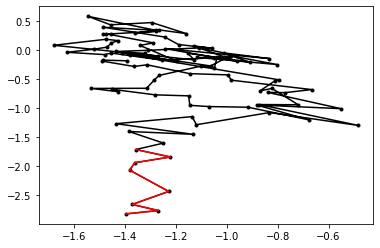

In [13]:
plt.plot(phi(trajectory), psi(trajectory), 'k.-')
plt.plot(phi(subtrajectories[0]), psi(subtrajectories[0]), 'r')

## Setting up another engine

We'll create another engine that uses a 300K integrator, and equilibrate to a 300K path from the 500K path.

In [14]:
engine = ops_gmx.Engine(gro="conf.gro",
                        mdp="md.mdp",
                        top="topol.top",
                        options=options,
                        base_dir=".",
                        prefix="equil").named("tps_equil")

## Equilibrate TPS

This is, again, a simple path sampling setup. We use the same `TPSNetwork` we'll use later, and only shooting moves. One the initial conditions are correctly set up, we run one step at a time until the initial trajectory is decorrelated.

This setup of a path sampler always consists of defining a `network` and a `move_scheme`. See toy model notebooks for further discussion.

In [15]:
network = paths.TPSNetwork(initial_states=C_7eq, final_states=alpha_R).named("tps_network")
scheme = paths.OneWayShootingMoveScheme(network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine)

In [16]:
# make subtrajectories into initial conditions (trajectories become a sampleset)
initial_conditions = scheme.initial_conditions_from_trajectories(subtrajectories)

No missing ensembles.
No extra ensembles.


In [17]:
# check that initial conditions are valid and complete (raise AssertionError otherwise)
scheme.assert_initial_conditions(initial_conditions)

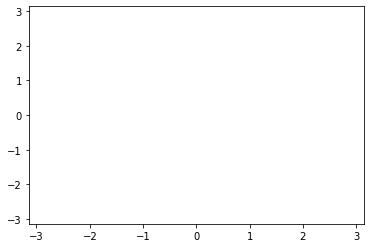

In [18]:
# use an empty background
(fig, ax) = plt.subplots()
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi);

In [19]:
sampler = paths.PathSampling(storage=paths.Storage("alanine_dipeptide_tps_equil.nc", "w", template),
                             move_scheme=scheme,
                             sample_set=initial_conditions)
sampler.live_visualizer = paths.StepVisualizer2D(network, phi, psi, [-np.pi, np.pi], [-np.pi, np.pi])
sampler.live_visualizer.background = fig

In [20]:
# initially, these trajectories are correlated (actually, identical)
# once decorrelated, we have a (somewhat) reasonable 300K trajectory
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

True

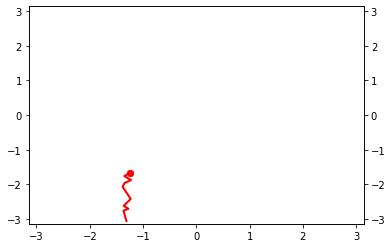

Step 4: All trajectories decorrelated!


In [21]:
# this is a trick to take the first decorrelated trajectory
sampler.run_until_decorrelated()

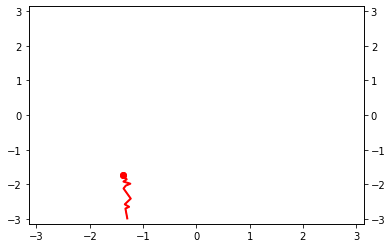

DONE! Completed 13 Monte Carlo cycles.


In [22]:
# run an extra 10 to decorrelate a little futher
sampler.run(10)

From here, you can either extend this to a longer trajectory for the fixed length TPS in the `alanine_dipeptide_fixed_tps_traj.ipynb` notebook, or go straight to flexible length TPS in the `alanine_dipeptide_tps_run.ipynb` notebook.

In [23]:
sampler.storage.close()